In [2]:
import os
import re
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from utils import *

### Log Paths

In [3]:
gimsatul_2x16_path = '../logs_gimsatul_2x16'
gimsatul_8x4_path = '../logs_gimsatul_8x4'
gim_search_only_path = '../logs_search_only_2x16'
kissat_baseline_path = '../logs_kissat'
kissat_search_only_path = '../logs_kissat_search_only'
plain_gimsatul_path = '../logs_plain_gimsatul'
serial_kissat_path = '../logs_serial'

### Select Paths for Comparison

In [4]:
solver_paths = [# kissat_baseline_path,
                kissat_search_only_path,
                # plain_gimsatul_path,
                # gim_search_only_path,
                serial_kissat_path,
                gimsatul_2x16_path]
solver_names = [#'Mallob_Kis',
                'Mallob_Kis_SO',
                # 'Plain_Gim',
                # 'Mallob_Gim_SO',
                'Serial',
                'Mallob_Gim_2x16',]

### Compare 2 Results

In [5]:
# get and merge benchmark meta data
df_ref = pd.read_csv('track_2023_database.csv', sep="\t")
df_meta = pd.read_csv('benchmark_meta_data.csv', sep='\t')
df_overview = df_meta.merge(df_ref[['filename', 'result']],
                                how='inner', left_on='name',
                                right_on='filename')
df_overview.drop(columns='filename', inplace=True)

# get and merge benchmark results per solver
for i in range(len(solver_paths)):
    df_overview = df_overview.merge(parse_overview(solver_paths[i], solver_names[i]),
                                    how='inner',
                                    on='name')
    
df_overview

,name,variables,clauses,result,Mallob_Kis_SO_result,Mallob_Kis_SO_memory,Mallob_Kis_SO_runtime,Serial_result,Serial_memory,Serial_runtime,Mallob_Gim_2x16_result,Mallob_Gim_2x16_memory,Mallob_Gim_2x16_runtime
0,hash_table_find_safety_size_23.cnf,14140522,64659736,unsat,-1,47.03,6.347183,-1,8.952087,142.20,0,38.34,0.000000
1,WCNF_from_fp_13.cnf,572,12199,unsat,-1,0.00,1.682471,-1,0.011837,6.69,0,2.29,0.000000
2,intervals753.cnf,2572,61869,unsat,0,2.72,0.000000,0,0.051300,299.92,0,2.61,0.000000
3,brent_69_0.3.cnf,81990,332066,sat,1,0.00,0.488077,1,0.037907,11.45,1,1.36,3.907797
4,WS_500_32_50_10.apx_2_DC-AD.cnf,1000,25001,unknown,0,1.99,0.000000,0,0.027431,299.67,0,1.38,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,grs-32-256.cnf,839258,2383464,unsat,0,7.74,0.000000,0,0.379288,299.15,0,7.50,0.000000
396,SCPC-800-50.cnf,800,33848,sat,1,0.92,39.115978,1,0.040691,72.88,1,1.55,12.498876
397,hash_table_find_safety_size_12.cnf,5861110,27150271,unsat,-1,36.58,2.382530,-1,3.726643,58.25,-1,29.93,115.166550
398,CNP-5-1100.cnf,22585,167911,sat,1,0.89,2.327481,1,0.034798,130.95,1,1.31,10.478599


In [6]:
match = True
gimsatul_win = 0
kissat_win = 0
wrong_results = 0
wrong_sat = 0
wrong_unsat = 0
kis_abs = 0
gim_abs = 0
for i, row in df_overview.iterrows():
    gr = row[f"{solver_names[0]}_result"]
    kr = row[f"{solver_names[-1]}_result"]
    if gr != 0:
        gim_abs += 1
    if kr != 0:
        kis_abs += 1
    if gr == kr:
        continue
    if gr == 0 and kr != 0:
        kissat_win += 1
        continue
    if gr != 0 and kr == 0:
        gimsatul_win += 1
        # sat = 'SAT' if gr == 1 else 'UNSAT'
        # print(f"name: {row['name']} result: {sat}")
        continue
    if gr == 1 and kr == -1:
        wrong_sat += 1
    if gr == -1 and kr == 1:
        wrong_unsat += 1
    match = False
    wrong_results += 1
    print(f"Discrepancy for benchmark {row['name']}")

if match: print(f"Results match")
else:
    print("Results don't match")
    print(f"wrong results: {wrong_results}")
    print(f"wrong SAT: {wrong_sat}")
    print(f"wrong UNSAT: {wrong_unsat}")
print(f"{solver_names[0]} wins: {gimsatul_win}")
print(f"{solver_names[-1]} wins: {kissat_win}")
print(f"{solver_names[0]}_abs: {gim_abs}")
print(f"{solver_names[-1]}_abs: {kis_abs}")
print()

# Checks Results against Database
correct = True
for i,row in df_overview.iterrows():
    sat_map = {'sat': 1, 'unsat': -1, 'unknown': 0, 1: 1, -1: -1, 0: 0}
    sat = set([sat_map[res] for res in row.filter(regex='result')])
    sat.discard(0)
    if not sat:         # result not known & not found
        continue
    if len(sat) == 1:   # all the results are the same
        continue
    if len(sat) > 1:
        print(f"WRONG RESULT IN ROW {i}: {row}")
        correct = False

if correct:
    print("Results match Database :)")


Results match
Mallob_Kis_SO wins: 63
Mallob_Gim_2x16 wins: 6
Mallob_Kis_SO_abs: 273
Mallob_Gim_2x16_abs: 216

Results match Database :)


### Notable Comparable Results against Kissat Baseline
#### Gimsatul_4x8:
Results match  
gimsatul wins: 3  
kissat wins: 40  
gim_abs: 206  
kis_abs: 243  

#### Gimsatul_2x16:
Results match  
gimsatul wins: 1  
kissat wins: 28  
gim_abs: 216  
kis_abs: 243  

#### Gimsatul_2x16_search_only:
Results match  
gimsatul wins: 3  
kissat wins: 28  
gim_abs: 218  
kis_abs: 243  

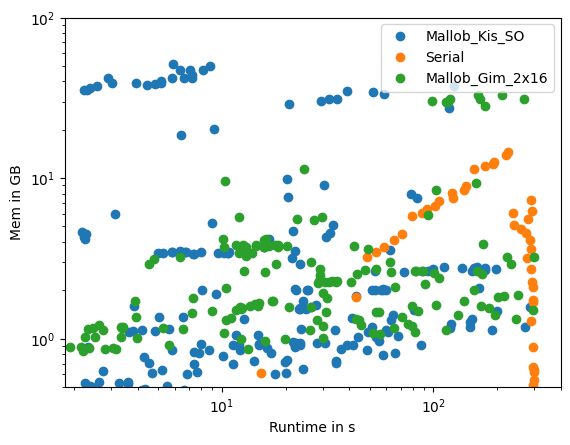

In [7]:
# plot memory
for name in solver_names:
    plt.plot(df_overview[f"{name}_runtime"], df_overview[f"{name}_memory"], 'o')
plt.axis([1.8,400,0.5,100])
plt.legend(solver_names)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Mem in GB')
plt.xlabel('Runtime in s')
plt.show()

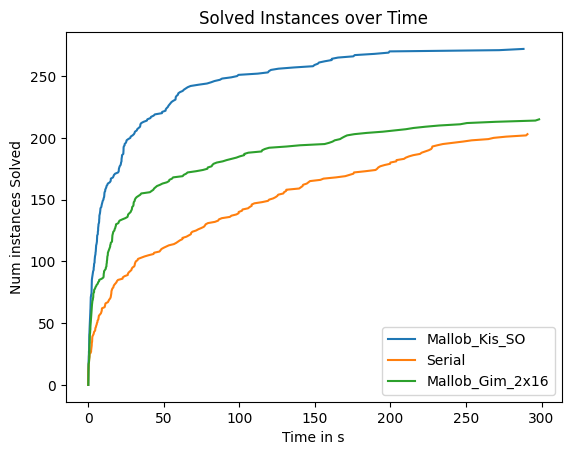

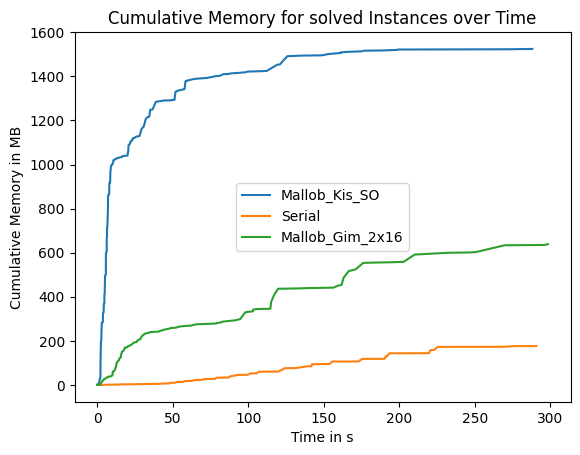

In [8]:
# Plot Cumulative runtime

for name in solver_names:
    subset = df_overview[df_overview[f"{name}_result"] != 0].sort_values(f"{name}_runtime")
    plt.plot(subset[f"{name}_runtime"], range(subset.__len__()))
plt.legend(solver_names)
plt.title('Solved Instances over Time')
plt.ylabel('Num instances Solved')
plt.xlabel('Time in s')
plt.show()

# Plot cumulative Memory

for name in solver_names:
    subset = df_overview[df_overview[f"{name}_result"] != 0].sort_values(f"{name}_runtime")
    cum_mem = np.cumsum(list(subset[f"{name}_memory"]))
    plt.plot(subset[f"{name}_runtime"], cum_mem)
plt.legend(solver_names)
plt.title('Cumulative Memory for solved Instances over Time')
plt.ylabel('Cumulative Memory in MB')
plt.xlabel('Time in s')
plt.show()

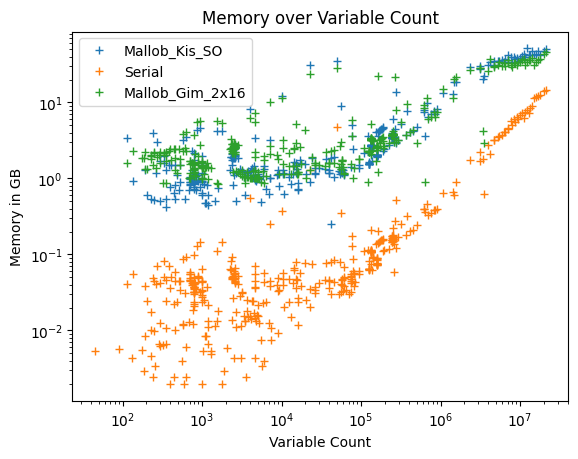

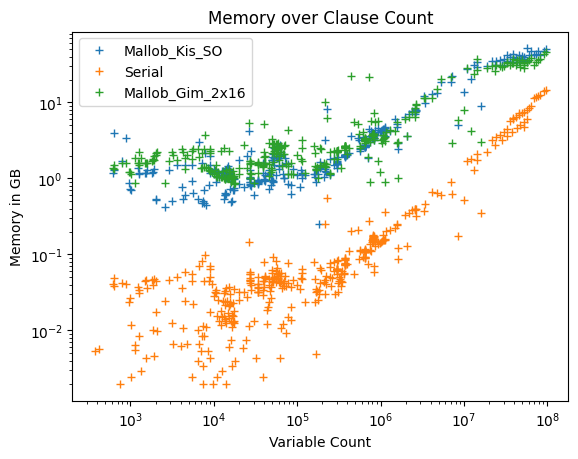

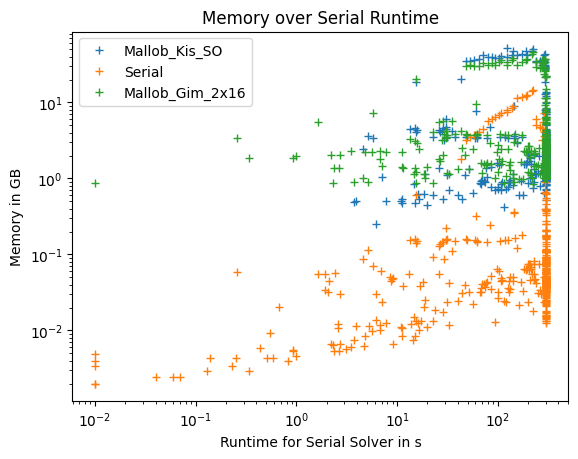

In [9]:
# Memory over Variable & Clause Counts
for name in solver_names:
    plt.plot(df_overview['variables'], df_overview[f"{name}_memory"], '+')
plt.legend(solver_names)
plt.xscale('log')
plt.yscale('log')
plt.title('Memory over Variable Count')
plt.xlabel('Variable Count')
plt.ylabel('Memory in GB')
plt.show()

for name in solver_names:
    plt.plot(df_overview['clauses'], df_overview[f"{name}_memory"], '+')
plt.legend(solver_names)
plt.xscale('log')
plt.yscale('log')
plt.title('Memory over Clause Count')
plt.xlabel('Variable Count')
plt.ylabel('Memory in GB')
plt.show()

for name in solver_names:
    plt.plot(df_overview['Serial_runtime'], df_overview[f"{name}_memory"], '+')
plt.legend(solver_names)
plt.xscale('log')
plt.yscale('log')
plt.title('Memory over Serial Runtime')
plt.xlabel('Runtime for Serial Solver in s')
plt.ylabel('Memory in GB')
plt.show()

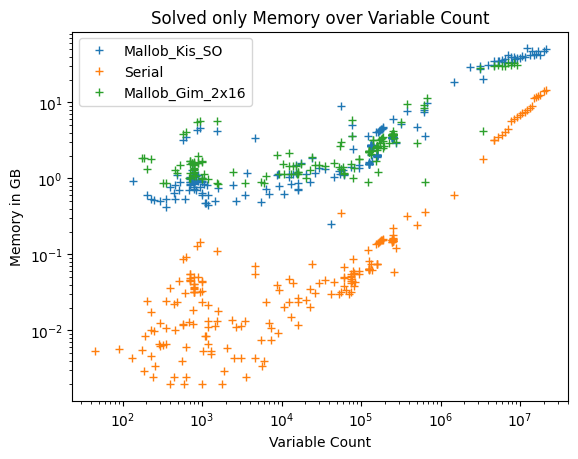

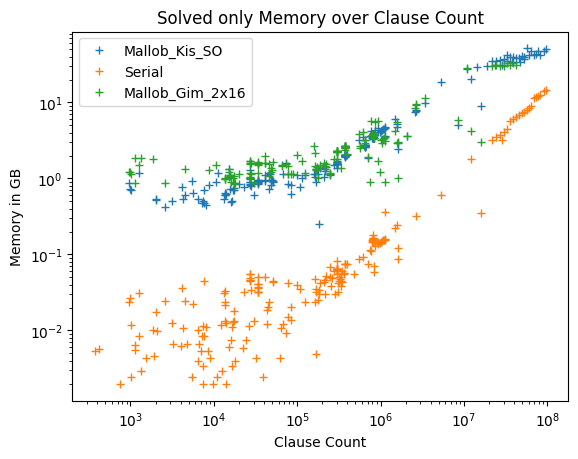

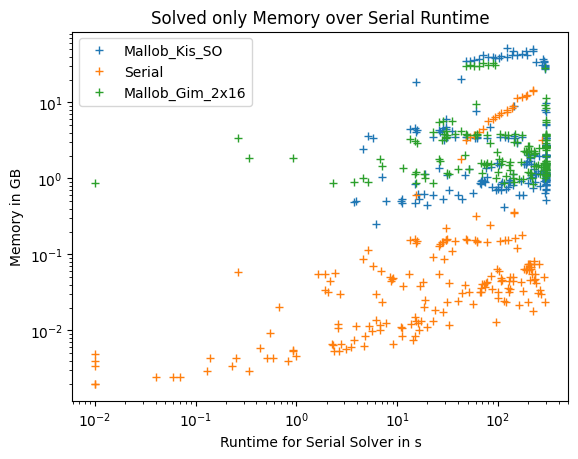

In [10]:
# Memory over Variable & Clause Counts for solved Instanzes only

for name in solver_names:
    subset = df_overview[df_overview[f"{name}_result"] != 0]
    plt.plot(subset['variables'], subset[f"{name}_memory"], '+')
plt.legend(solver_names)
plt.xscale('log')
plt.yscale('log')
plt.title('Solved only Memory over Variable Count')
plt.xlabel('Variable Count')
plt.ylabel('Memory in GB')
plt.show()

for name in solver_names:
    subset = df_overview[df_overview[f"{name}_result"] != 0]
    plt.plot(subset['clauses'], subset[f"{name}_memory"], '+')
plt.legend(solver_names)
plt.xscale('log')
plt.yscale('log')
plt.title('Solved only Memory over Clause Count')
plt.xlabel('Clause Count')
plt.ylabel('Memory in GB')
plt.show()

for name in solver_names:
    subset = df_overview[df_overview[f"{name}_result"] != 0]
    plt.plot(subset['Serial_runtime'], subset[f"{name}_memory"], '+')
plt.legend(solver_names)
plt.xscale('log')
plt.yscale('log')
plt.title('Solved only Memory over Serial Runtime')
plt.xlabel('Runtime for Serial Solver in s')
plt.ylabel('Memory in GB')
plt.show()

In [11]:
# Perpare Dataframes for 2D plots
# Contains only instances that have been solved by both Algorithms

solver_1_name = solver_names[0]
solver_2_name = solver_names[-1]

solver_1_path = solver_paths[0]
solver_2_path = solver_paths[-1]

df_solved = df_overview[[f"{solver_1_name}_result",
                         f"{solver_1_name}_memory",
                         f"{solver_1_name}_runtime",
                         f"{solver_2_name}_result",
                         f"{solver_2_name}_memory",
                         f"{solver_2_name}_runtime",
                         'Serial_runtime',
                         'variables',
                         'clauses']]
df_solved = df_solved[df_solved[f"{solver_1_name}_result"] != 0]
df_solved = df_solved[df_solved[f"{solver_2_name}_result"] != 0]

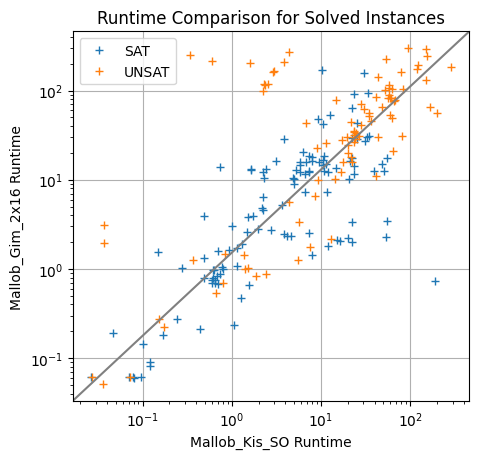

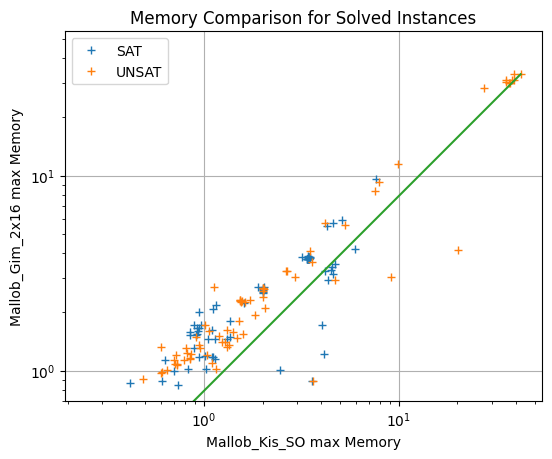

In [36]:
# 2D Runtimes for solved instances only

plt.plot(df_solved[df_solved[f"{solver_1_name}_result"] == 1][f"{solver_1_name}_runtime"],
         df_solved[df_solved[f"{solver_2_name}_result"] == 1][f"{solver_2_name}_runtime"],
         '+')
plt.plot(df_solved[df_solved[f"{solver_1_name}_result"] == -1][f"{solver_1_name}_runtime"],
         df_solved[df_solved[f"{solver_2_name}_result"] == -1][f"{solver_2_name}_runtime"],
         '+')
plt.xscale('log')
plt.yscale('log')
plt.legend(['SAT', 'UNSAT'])
plt.title('Runtime Comparison for Solved Instances')
plt.xlabel(f"{solver_1_name} Runtime")
plt.ylabel(f"{solver_2_name} Runtime")
plt.axis('square')
ax = plt.subplot()
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='grey')
plt.grid()
plt.show()


# 2D Mem for solved instances only

plt.plot(df_solved[df_solved[f"{solver_1_name}_result"] == 1][f"{solver_1_name}_memory"],
         df_solved[df_solved[f"{solver_2_name}_result"] == 1][f"{solver_2_name}_memory"],
         '+')
plt.plot(df_solved[df_solved[f"{solver_1_name}_result"] == -1][f"{solver_1_name}_memory"],
         df_solved[df_solved[f"{solver_2_name}_result"] == -1][f"{solver_2_name}_memory"],
         '+')
plt.plot([0, max(df_solved[df_solved[f"{solver_1_name}_result"] != 0][f"{solver_1_name}_memory"])],
         [0, max(df_solved[df_solved[f"{solver_2_name}_result"] != 0][f"{solver_2_name}_memory"])])
plt.xscale('log')
plt.yscale('log')
plt.legend(['SAT', 'UNSAT'])
plt.title('Memory Comparison for Solved Instances')
plt.xlabel(f"{solver_1_name} max Memory")
plt.ylabel(f"{solver_2_name} max Memory")
plt.axis('square')
#ax = plt.subplot()
#ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='grey')
plt.grid()
plt.show()

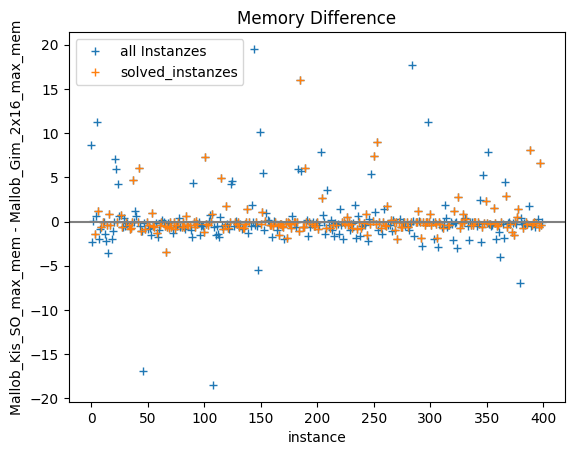

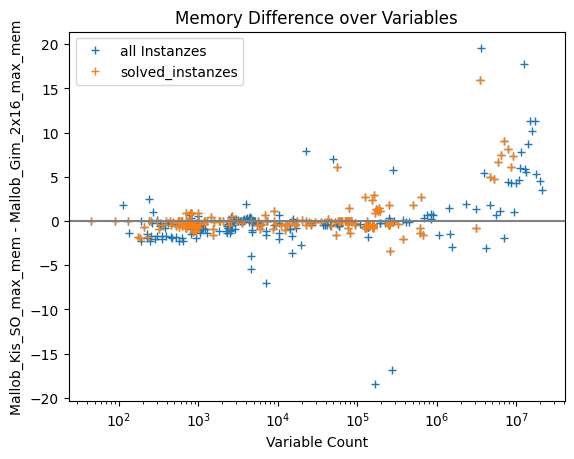

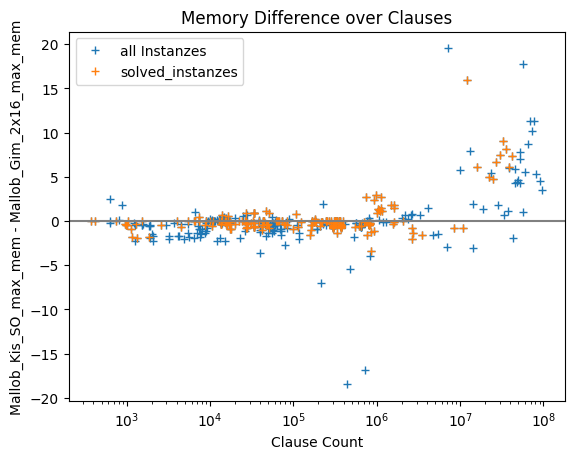

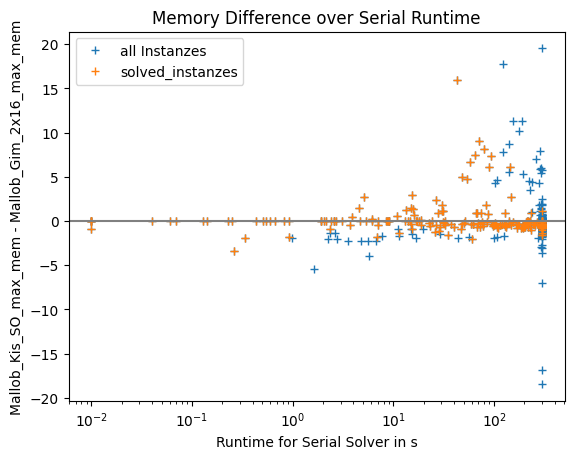

In [13]:
# Plot max memory diff
diff = [row[f"{solver_1_name}_memory"] - row[f"{solver_2_name}_memory"]
        for i, row in df_overview.iterrows()]
diff_solved = [row[f"{solver_1_name}_memory"] - row[f"{solver_2_name}_memory"]
               for i, row in df_solved.iterrows()]

plt.plot(df_overview.index, diff, '+')
plt.plot(df_solved.index, diff_solved, '+')
plt.legend(['all Instanzes', 'solved_instanzes'])
plt.axhline(y=0, color='grey')
plt.title('Memory Difference')
plt.ylabel(f"{solver_1_name}_max_mem - {solver_2_name}_max_mem")
plt.xlabel('instance')
plt.show()

plt.plot(df_overview['variables'], diff, '+')
plt.plot(df_solved['variables'], diff_solved, '+')
plt.legend(['all Instanzes', 'solved_instanzes'])
plt.axhline(y=0, color='grey')
plt.title('Memory Difference over Variables')
plt.xscale('log')
#plt.yscale('log')
plt.ylabel(f"{solver_1_name}_max_mem - {solver_2_name}_max_mem")
plt.xlabel('Variable Count')
plt.show()

plt.plot(df_overview['clauses'], diff, '+')
plt.plot(df_solved['clauses'], diff_solved, '+')
plt.legend(['all Instanzes', 'solved_instanzes'])
plt.axhline(y=0, color='grey')
plt.title('Memory Difference over Clauses')
plt.xscale('log')
#plt.yscale('log')
plt.ylabel(f"{solver_1_name}_max_mem - {solver_2_name}_max_mem")
plt.xlabel('Clause Count')
plt.show()

plt.plot(df_overview['Serial_runtime'], diff, '+')
plt.plot(df_solved['Serial_runtime'], diff_solved, '+')
plt.legend(['all Instanzes', 'solved_instanzes'])
plt.axhline(y=0, color='grey')
plt.title('Memory Difference over Serial Runtime')
plt.xscale('log')
#plt.yscale('log')
plt.ylabel(f"{solver_1_name}_max_mem - {solver_2_name}_max_mem")
plt.xlabel('Runtime for Serial Solver in s')
plt.show()

outlier for ratio > 7: baseballcover13with25_and3positions.cnf
outlier for ratio > 2: Urquhart-s5-b4.shuffled.cnf
outlier for ratio > 2: baseballcover13with25_and3positions.cnf
outlier for ratio > 2: g2-T99.2.0.cnf
outlier for ratio > 2: crafted_n12_d6_c4_num4.cnf
outlier for ratio > 2: PRP_20_40.cnf
outlier for ratio > 2: shift1add.28943.cnf
outlier for ratio > 2: tseitin_d3_n160.cnf
outlier for ratio > 2: PRP_20_50.cnf
outlier for ratio > 2: PRP_30_35.cnf
outlier for ratio > 2: patat-08-comp-3.cnf


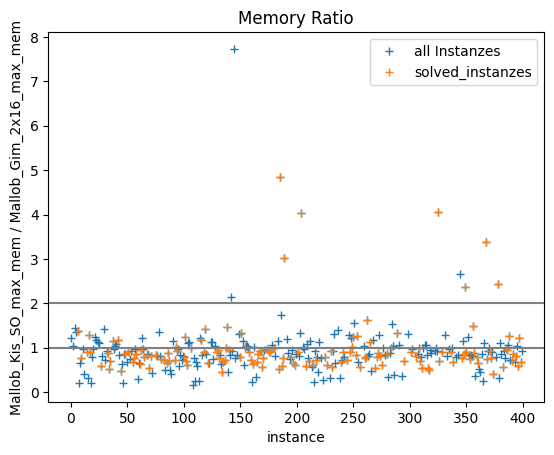

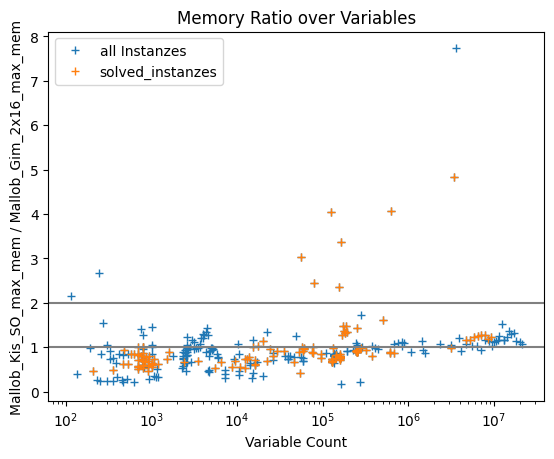

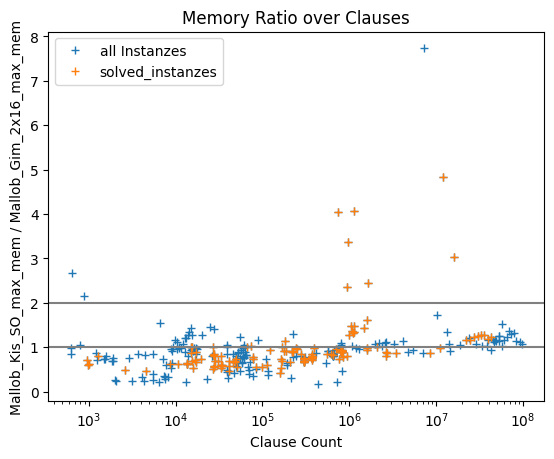

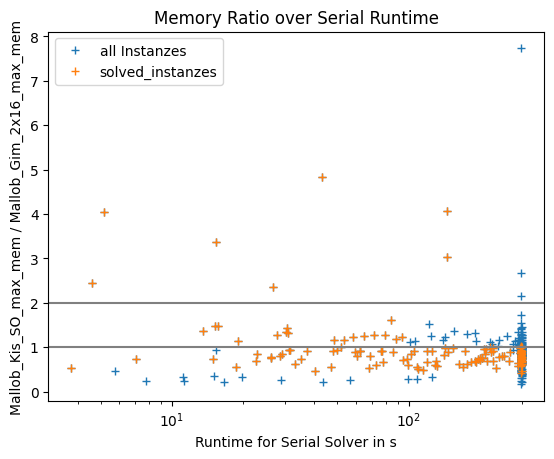

In [50]:
# Plot max memory ratios

subset = df_overview[df_overview[f"{solver_1_name}_memory"] > 0]
subset = subset[subset[f"{solver_2_name}_memory"] > 0]

subset_solved = df_solved[df_solved[f"{solver_1_name}_memory"] > 0]
subset_solved = subset_solved[subset_solved[f"{solver_2_name}_memory"] > 0]

ratios = [row[f"{solver_1_name}_memory"] / row[f"{solver_2_name}_memory"]
        for i, row in subset.iterrows()]
ratios_solved = [row[f"{solver_1_name}_memory"] / row[f"{solver_2_name}_memory"]
               for i, row in subset_solved.iterrows()]

print(f"outlier for ratio > 7: {list(subset.reset_index()['name'])[ratios.index(max(ratios))]}")
for i in range(len(ratios)):
    if ratios[i] >= 2:
        print(f"outlier for ratio > 2: {list(subset.reset_index()['name'])[i]}")

plt.plot(subset.index, ratios, '+')
plt.plot(subset_solved.index, ratios_solved, '+')
plt.legend(['all Instanzes', 'solved_instanzes'])
plt.axhline(y=1, color='grey')
plt.axhline(y=2, color='grey')
plt.title('Memory Ratio')
plt.ylabel(f"{solver_1_name}_max_mem / {solver_2_name}_max_mem")
plt.xlabel('instance')
plt.show()

plt.plot(subset['variables'], ratios, '+')
plt.plot(subset_solved['variables'], ratios_solved, '+')
plt.legend(['all Instanzes', 'solved_instanzes'])
plt.axhline(y=1, color='grey')
plt.axhline(y=2, color='grey')
plt.title('Memory Ratio over Variables')
plt.xscale('log')
#plt.yscale('log')
plt.ylabel(f"{solver_1_name}_max_mem / {solver_2_name}_max_mem")
plt.xlabel('Variable Count')
plt.show()

plt.plot(subset['clauses'], ratios, '+')
plt.plot(subset_solved['clauses'], ratios_solved, '+')
plt.legend(['all Instanzes', 'solved_instanzes'])
plt.axhline(y=1, color='grey')
plt.axhline(y=2, color='grey')
plt.title('Memory Ratio over Clauses')
plt.xscale('log')
#plt.yscale('log')
plt.ylabel(f"{solver_1_name}_max_mem / {solver_2_name}_max_mem")
plt.xlabel('Clause Count')
plt.show()

plt.plot(subset['Serial_runtime'], ratios, '+')
plt.plot(subset_solved['Serial_runtime'], ratios_solved, '+')
plt.legend(['all Instanzes', 'solved_instanzes'])
plt.axhline(y=1, color='grey')
plt.axhline(y=2, color='grey')
plt.title('Memory Ratio over Serial Runtime')
plt.xscale('log')
#plt.yscale('log')
plt.ylabel(f"{solver_1_name}_max_mem / {solver_2_name}_max_mem")
plt.xlabel('Runtime for Serial Solver in s')
plt.show()

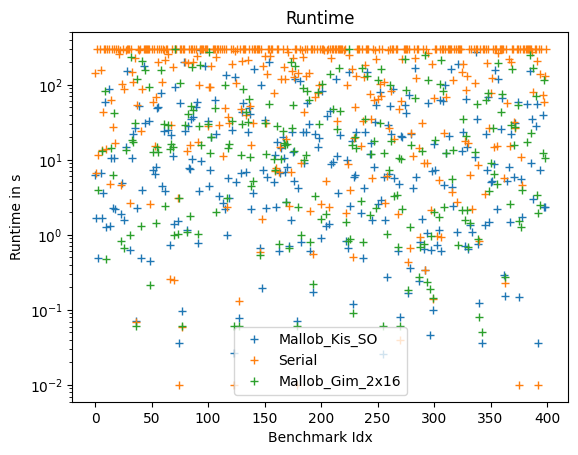

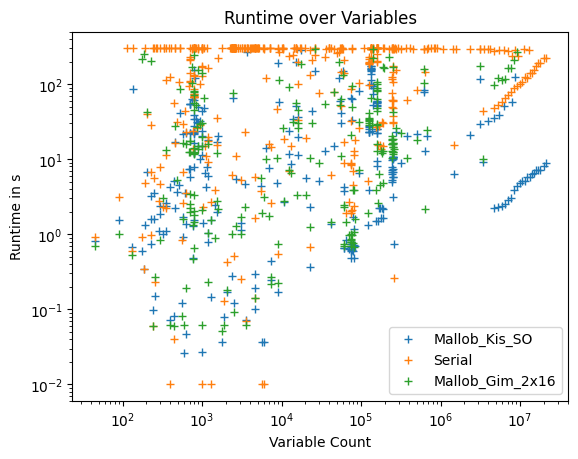

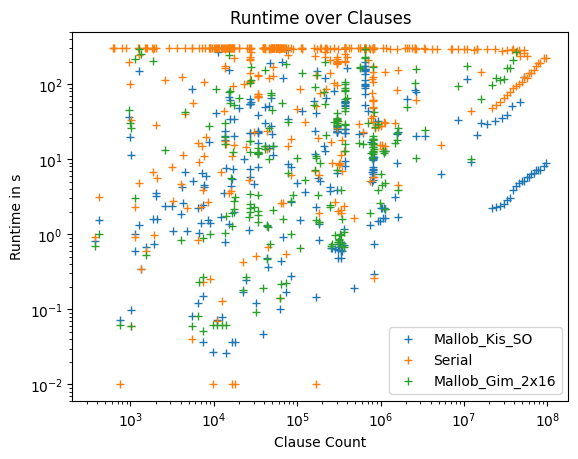

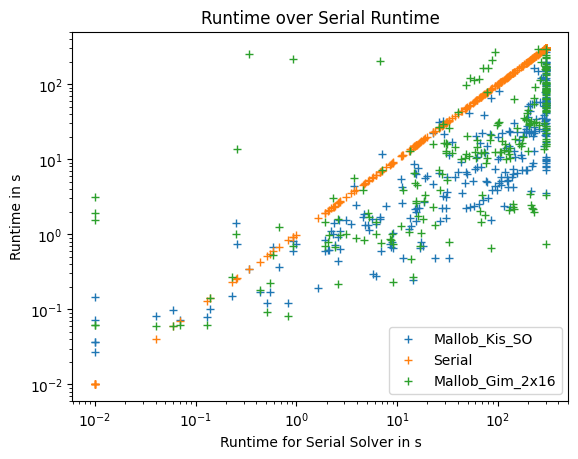

In [15]:
# Plot runtime
for name in solver_names:
    plt.plot(df_overview[f"{name}_runtime"], '+')
plt.legend(solver_names)
plt.title('Runtime')
plt.yscale('log')
plt.ylabel('Runtime in s')
plt.xlabel('Benchmark Idx')
plt.show()

for name in solver_names:
    plt.plot(df_overview['variables'], df_overview[f"{name}_runtime"], '+')
plt.legend(solver_names)
plt.title('Runtime over Variables')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Runtime in s')
plt.xlabel('Variable Count')
plt.show()

for name in solver_names:
    plt.plot(df_overview['clauses'], df_overview[f"{name}_runtime"], '+')
plt.legend(solver_names)
plt.title('Runtime over Clauses')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Runtime in s')
plt.xlabel('Clause Count')
plt.show()

for name in solver_names:
    plt.plot(df_overview['Serial_runtime'], df_overview[f"{name}_runtime"], '+')
plt.legend(solver_names)
plt.xscale('log')
plt.yscale('log')
plt.title('Runtime over Serial Runtime')
plt.xlabel('Runtime for Serial Solver in s')
plt.ylabel('Runtime in s')
plt.show()

Geometric mean of geometric means: 1.3385822179700924


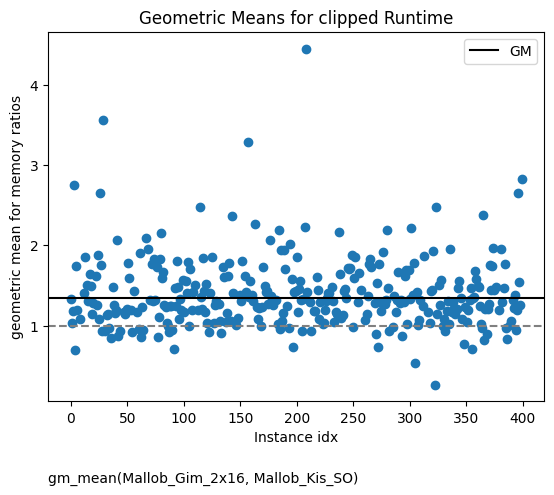

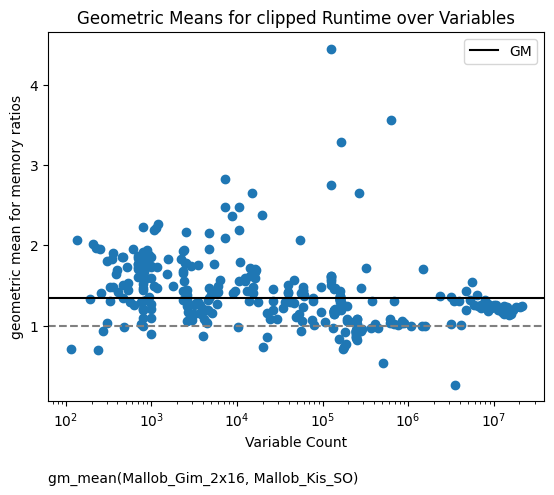

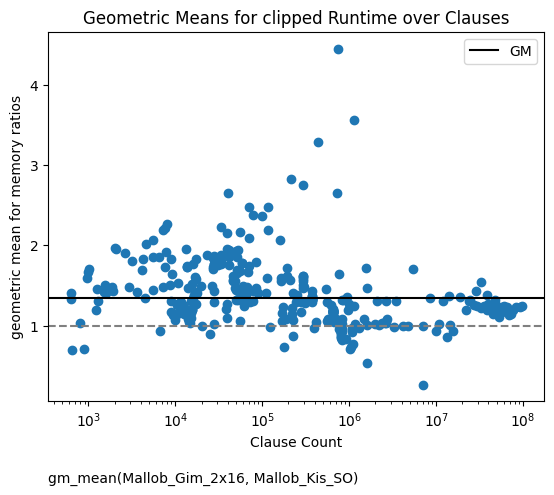

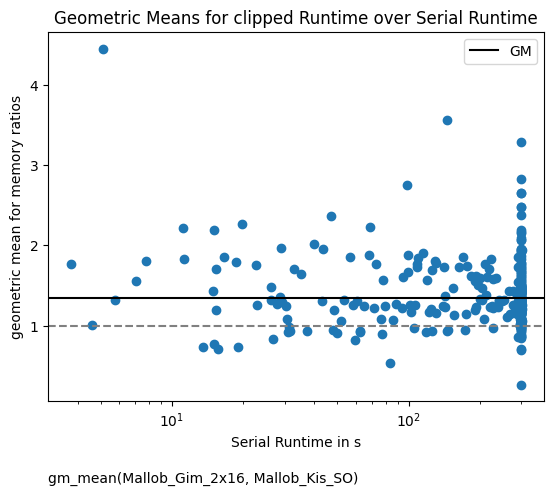

In [29]:
from statistics import geometric_mean

df_mem_gim = parse_mem(solver_2_path, solver_2_name)
df_mem_kis = parse_mem(solver_1_path, solver_1_name)
df_mem = df_mem_gim.merge(df_mem_kis, how='inner', on='name')

gms = []
for i, row in df_mem.iterrows():
    gim_mem = row[f"{solver_2_name}_mem_per_sec"]
    kis_mem = row[f"{solver_1_name}_mem_per_sec"]
    
    l = min([len(gim_mem), len(kis_mem)])
    gim_mem = gim_mem[1:l]
    kis_mem = kis_mem[1:l]

    ratios = [ g / k for g, k in zip(gim_mem, kis_mem)]
    if len(ratios) <= 0:
        gms.append(0)
    else:
        gms.append(geometric_mean(ratios))

df_mem['geo_means'] = gms
df_mem = df_mem.merge(df_overview[['name', 'variables', 'clauses', 'Serial_runtime']], how='inner', on='name')
df_mem = df_mem[df_mem['geo_means'] > 0]

# Geometric mean of geometric means
GM = geometric_mean(df_mem['geo_means'])
print(f"Geometric mean of geometric means: {GM}")

plt.plot(df_mem.index, df_mem['geo_means'], 'o')
plt.axhline(y=1, linestyle='dashed', color='grey')
plt.axhline(y=GM, color='black', label='GM')
plt.legend()
plt.title('Geometric Means for clipped Runtime')
plt.annotate(f"gm_mean({solver_2_name}, {solver_1_name})",
             (0,0),
             (0, -50),
             xycoords='axes fraction',
             textcoords='offset points',
             va='top')
plt.xlabel('Instance idx')
plt.ylabel('geometric mean for memory ratios')
plt.show()

plt.plot(df_mem['variables'], df_mem['geo_means'], 'o')
plt.axhline(y=1, linestyle='dashed', color='grey')
plt.axhline(y=GM, color='black', label='GM')
plt.legend()
plt.title('Geometric Means for clipped Runtime over Variables')
plt.annotate(f"gm_mean({solver_2_name}, {solver_1_name})",
             (0,0),
             (0, -50),
             xycoords='axes fraction',
             textcoords='offset points',
             va='top')
plt.xscale('log')
plt.xlabel('Variable Count')
plt.ylabel('geometric mean for memory ratios')
plt.show()

plt.plot(df_mem['clauses'], df_mem['geo_means'], 'o')
plt.axhline(y=1, linestyle='dashed', color='grey')
plt.axhline(y=GM, color='black', label='GM')
plt.legend()
plt.title('Geometric Means for clipped Runtime over Clauses')
plt.annotate(f"gm_mean({solver_2_name}, {solver_1_name})",
             (0,0),
             (0, -50),
             xycoords='axes fraction',
             textcoords='offset points',
             va='top')
plt.xscale('log')
plt.xlabel('Clause Count')
plt.ylabel('geometric mean for memory ratios')
plt.show()

plt.plot(df_mem['Serial_runtime'], df_mem['geo_means'], 'o')
plt.axhline(y=1, linestyle='dashed', color='grey')
plt.axhline(y=GM, color='black', label='GM')
plt.legend()
plt.title('Geometric Means for clipped Runtime over Serial Runtime')
plt.annotate(f"gm_mean({solver_2_name}, {solver_1_name})",
             (0,0),
             (0, -50),
             xycoords='axes fraction',
             textcoords='offset points',
             va='top')
plt.xscale('log')
plt.xlabel('Serial Runtime in s')
plt.ylabel('geometric mean for memory ratios')
plt.show()

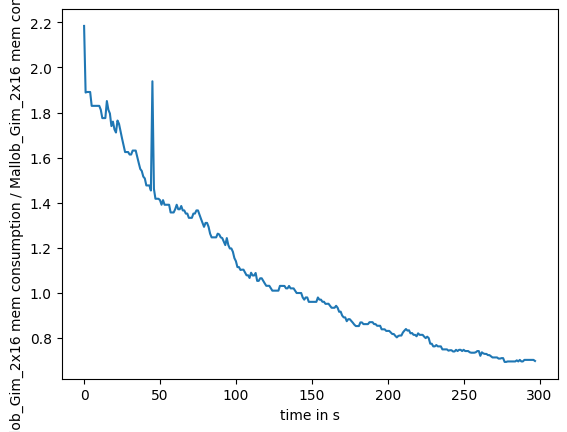

In [17]:
max_len = 0
glob_gim_mem = []
glob_kis_mem = []
name = ''

# find longest chain
for i, row in df_mem.iterrows():
    gim_mem = row[f"{solver_2_name}_mem_per_sec"]
    kis_mem = row[f"{solver_1_name}_mem_per_sec"]
    
    l = min([len(gim_mem), len(kis_mem)])
    if l > max_len:
        max_len = l
        glob_gim_mem = gim_mem[1:l]
        glob_kis_mem = kis_mem[1:l]
        name = row['name']

ratios = [ g / k for g, k in zip(glob_gim_mem, glob_kis_mem)]
plt.plot(range(max_len - 1), ratios)
plt.ylabel(f"{solver_2_name} mem consumption / {solver_2_name} mem consumption")
plt.xlabel('time in s')
plt.show()

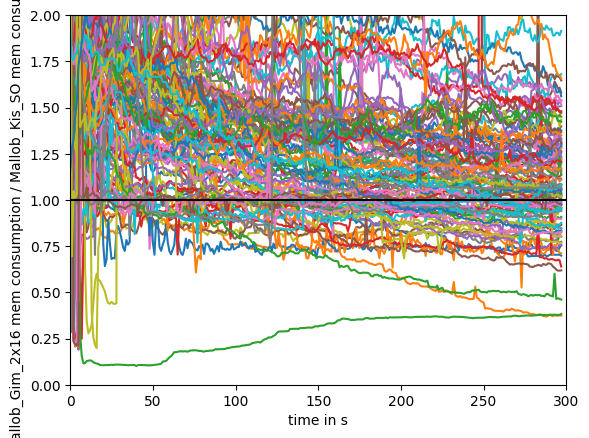

In [31]:
names = []
for i, row in df_mem.iterrows():
    gim_mem = row[f"{solver_2_name}_mem_per_sec"]
    kis_mem = row[f"{solver_1_name}_mem_per_sec"]
    
    l = min([len(gim_mem), len(kis_mem)])
    if l >= 299:
        ratios = [ g / k for g, k in zip(gim_mem[1:l], kis_mem[1:l])]
        plt.plot(range(max_len - 1), ratios)
        names.append(row['name'])

plt.axis([0,300,0,2])
plt.axhline(y=1, color='black')
plt.ylabel(f"{solver_2_name} mem consumption / {solver_1_name} mem consumption")
plt.xlabel('time in s')
plt.show()
